<a href="https://colab.research.google.com/github/SydAt1/Emotion_Detection_AML/blob/main/initial_DistilBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 4.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from transformers import DistilBertTokenizer
import torch as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Custom Dataset class for BERT
class EmotionDataset(nn.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = nn.tensor(labels, dtype=nn.float32)  # Multi-label = float32

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

### I had to run it on google colab for doing some finetuning on Nvidia GPU

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Loading the dataset
df = pd.read_csv('/content/drive/MyDrive/Text_Emotion_Classifier-master/dataset/preprocessed_go_emotions.csv')
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

texts = df["text"].astype(str).tolist()
labels = df.drop(columns=["text"]).values

In [ ]:
print("Number of duplicate rows:", df.duplicated().sum())
print("df shape:", df.shape)
print("Number of unique rows:", df.drop_duplicates().shape[0])

Number of duplicate rows: 56410
df shape: (207814, 31)
Number of unique rows: 151404


In [ ]:
df_unique = df.drop_duplicates()
print("df_unique shape:", df_unique.shape)

df_unique shape: (151404, 31)


In [ ]:
X = df['cleaned_text'].values.reshape(-1, 1)

In [ ]:
# Perform multi-label stratified split
X_train, y_train, X_test, y_test = iterative_train_test_split(X, labels, test_size=0.2)
# Further split training data for validation
val_size = 0.2  # 20% of the training set
X_train_new, y_train_new, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=val_size / (1 - 0.2))

In [ ]:
# Converting everything to string
X_train = [str(x) for x in X_train if x is not None]
X_val   = [str(x) for x in X_val if x is not None]
X_test  = [str(x) for x in X_test if x is not None]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=64, # Originally 128, but for KFold 64, need fast results
        return_tensors='pt' # PyTorch tensors instead of TensorFlow
    )

train_encodings = tokenize_texts(X_train)
val_encodings = tokenize_texts(X_val)
test_encodings = tokenize_texts(X_test)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### Creating PyTorch Data Loader

#### PyTorch provides two data primitives:
* Dataset stores the samples and their corresponding labels,
* DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

In [ ]:
train_dataset = EmotionDataset(train_encodings, y_train)
val_dataset   = EmotionDataset(val_encodings, y_val)
test_dataset  = EmotionDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)


### Now finally using DistilBERT

In [ ]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=28,  # Change this to match your number of emotions
    problem_type="multi_label_classification"
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Setting up Optimizer and Loss function

In [ ]:
from torch.optim import AdamW
import torch

optimizer = AdamW(model.parameters(), lr=5e-5)

# for some reason torch.nn works and nn.BCEWithLogitsLoss() does not
loss_fn = torch.nn.BCEWithLogitsLoss()# Binary Cross Entropy for multi-label

In [ ]:
import transformers
print(nn.__version__)

2.7.1+cpu


In [ ]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move model to GPU

def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0

    for batch in tqdm(loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(loader)


In [ ]:
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            # Move data to GPU
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Collect predictions and labels on CPU for evaluation
            preds = torch.sigmoid(logits).detach().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), all_preds, all_labels

In [ ]:
for epoch in range(3):  # Adjust based on validation performance
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
    val_loss, val_preds, val_labels = evaluate(model, val_loader, loss_fn)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

100%|██████████| 10392/10392 [28:55<00:00,  5.99it/s]


Epoch 1 | Train Loss: 0.1285 | Val Loss: 0.1172


100%|██████████| 10392/10392 [28:59<00:00,  5.97it/s]


Epoch 2 | Train Loss: 0.1179 | Val Loss: 0.1085


100%|██████████| 10392/10392 [28:59<00:00,  5.97it/s]


Epoch 3 | Train Loss: 0.1111 | Val Loss: 0.1000


In [ ]:
save_path = '/content/drive/MyDrive/Text_Emotion_Classifier-master/model'

In [ ]:
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('/content/drive/MyDrive/Text_Emotion_Classifier-master/model/tokenizer_config.json',
 '/content/drive/MyDrive/Text_Emotion_Classifier-master/model/special_tokens_map.json',
 '/content/drive/MyDrive/Text_Emotion_Classifier-master/model/vocab.txt',
 '/content/drive/MyDrive/Text_Emotion_Classifier-master/model/added_tokens.json')

In [ ]:
from sklearn.metrics import f1_score, classification_report
import numpy as np

# Convert sigmoid outputs to binary predictions
threshold = 0.5
val_preds_bin = (np.array(val_preds) >= threshold).astype(int)
val_labels_bin = np.array(val_labels)

# Compute micro and macro F1-scores
micro_f1 = f1_score(val_labels_bin, val_preds_bin, average='micro')
macro_f1 = f1_score(val_labels_bin, val_preds_bin, average='macro')

print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")

# Detailed report for each label
print("\nClassification Report:")
print(classification_report(val_labels_bin, val_preds_bin))


Micro F1-score: 0.4039
Macro F1-score: 0.2635

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.58      0.64      3426
           1       0.71      0.51      0.59      1849
           2       0.70      0.20      0.31      1617
           3       0.82      0.01      0.03      2723
           4       0.74      0.08      0.15      3524
           5       0.64      0.16      0.25      1200
           6       0.83      0.08      0.15      1472
           7       0.83      0.11      0.19      1938
           8       0.60      0.18      0.28       764
           9       0.74      0.03      0.05      1694
          10       0.68      0.07      0.13      2285
          11       0.84      0.11      0.19      1060
          12       0.81      0.08      0.15       495
          13       0.80      0.09      0.17      1126
          14       0.72      0.35      0.47       640
          15       0.91      0.76      0.83      2325
          1

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def predict_text(text, threshold=0.5):
    # Tokenize input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=128
    ).to(device)

    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    # Convert probabilities to binary predictions
    predictions = (probs >= threshold).astype(int)
    return probs, predictions


In [ ]:
text = "I am so happy and grateful today!"
probs, preds = predict_text(text)

print("Probabilities:", probs)
print("Predictions:", preds)  # 1 = label is active

Probabilities: [1.8512140e-01 9.2636617e-03 6.2307529e-04 2.3495404e-03 6.6432841e-02
 7.1975686e-02 1.9946822e-03 9.7028259e-03 1.7467787e-02 4.3959687e-03
 6.1273761e-03 4.2760267e-04 6.9467380e-04 1.5030392e-01 2.4633360e-04
 2.6239330e-01 2.4077210e-04 6.1180192e-01 2.4258377e-02 4.9121544e-04
 7.0494175e-02 1.8043924e-02 6.6256006e-03 3.2224089e-02 8.1233220e-04
 2.7415599e-03 5.7514161e-03 3.8587768e-02]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [ ]:
labels = emotion_columns
active_labels = [labels[i] for i, p in enumerate(preds) if p == 1]
print("Predicted labels:", active_labels)

Predicted labels: ['joy']


### I am going to load the data here

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
model_path = "/content/drive/MyDrive/Text_Emotion_Classifier-master/model"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mount Google Drive first
from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/MyDrive/Text_Emotion_Classifier-master/model/Kfold"
os.makedirs(save_dir, exist_ok=True)

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    fold_path = os.path.join(save_dir, f"fold{fold+1}_model")

    # Skip if already trained and saved
    if os.path.exists(fold_path):
        print(f"Fold {fold+1} already trained, skipping...")
        continue

    print(f"Starting Fold {fold + 1}")

    # First just split data
    X_train = [str(X[i]) for i in train_index]
    X_val   = [str(X[i]) for i in val_index]
    y_train, y_val = labels[train_index], labels[val_index]

    # Second tokenize that
    train_encodings = tokenize_texts(X_train)
    val_encodings   = tokenize_texts(X_val)

    # Third create Datasets and DataLoaders
    train_dataset = EmotionDataset(train_encodings, y_train)
    val_dataset   = EmotionDataset(val_encodings, y_val)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=16)

    # Initialize model and optimizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # 5. Training loop
    for epoch in range(2):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
        val_loss, val_preds, val_labels = evaluate(model, val_loader, loss_fn)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # 6. Save after each fold
    model.save_pretrained(fold_path)
    tokenizer.save_pretrained(fold_path)
    np.save(os.path.join(save_dir, f"fold{fold+1}_val_preds.npy"), val_preds)
    np.save(os.path.join(save_dir, f"fold{fold+1}_val_labels.npy"), val_labels)
    print(f"✅ Fold {fold+1} saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting Fold 1


100%|██████████| 8659/8659 [13:38<00:00, 10.58it/s]


Epoch 1 | Train Loss: 0.1042 | Val Loss: 0.1029


100%|██████████| 8659/8659 [13:39<00:00, 10.57it/s]


Epoch 2 | Train Loss: 0.0979 | Val Loss: 0.1054
✅ Fold 1 saved to Google Drive!
Starting Fold 2


100%|██████████| 8659/8659 [13:39<00:00, 10.56it/s]


Epoch 1 | Train Loss: 0.1044 | Val Loss: 0.1024


100%|██████████| 8659/8659 [13:39<00:00, 10.57it/s]


Epoch 2 | Train Loss: 0.0979 | Val Loss: 0.1052
✅ Fold 2 saved to Google Drive!
Starting Fold 3


100%|██████████| 8659/8659 [13:38<00:00, 10.58it/s]


Epoch 1 | Train Loss: 0.1043 | Val Loss: 0.1024


100%|██████████| 8659/8659 [13:38<00:00, 10.58it/s]


Epoch 2 | Train Loss: 0.0980 | Val Loss: 0.1051
✅ Fold 3 saved to Google Drive!


In [ ]:
from sklearn.metrics import f1_score

val_preds_all = []
val_labels_all = []

for fold in range(1, 4):
    preds = np.load(f"/content/drive/MyDrive/Text_Emotion_Classifier-master/model/Kfold/fold{fold}_val_preds.npy")
    labels = np.load(f"/content/drive/MyDrive/Text_Emotion_Classifier-master/model/Kfold/fold{fold}_val_labels.npy")
    val_preds_all.append(preds)
    val_labels_all.append(labels)

val_preds_all = np.concatenate(val_preds_all, axis=0)
val_labels_all = np.concatenate(val_labels_all, axis=0)

# Assuming multi-label sigmoid outputs, threshold preds at 0.5 for binary predictions
val_preds_binary = (val_preds_all >= 0.5).astype(int)

f1 = f1_score(val_labels_all, val_preds_binary, average='micro')
print(f"Overall F1 score across folds: {f1:.4f}")

Overall F1 score across folds: 0.4134


In [ ]:
import os
import re

def get_completed_hyperparams(save_dir):
    """
    Checks which hyperparameter combinations have already been trained
    based on saved folders like best_model_lr{lr}_bs{bs}_fold{fold}.

    Returns:
        dict: {(lr, bs): [folds_completed]}
    """
    completed = {}

    # Regex to capture lr, bs, fold info
    pattern = re.compile(r'best_model_lr([\d\.e-]+)_bs(\d+)_fold(\d+)')

    for folder in os.listdir(save_dir):
        match = pattern.match(folder)
        if match:
            lr = float(match.group(1))
            bs = int(match.group(2))
            fold = int(match.group(3))

            completed.setdefault((lr, bs), []).append(fold)

    return completed

# Example usage:
save_dir = "/content/drive/MyDrive/Text_Emotion_Classifier-master/model/Hypermeter_tuning"
completed = get_completed_hyperparams(save_dir)

print("Already tuned hyperparameters and folds:")
for (lr, bs), folds in completed.items():
    print(f"  lr={lr}, bs={bs} -> folds: {sorted(folds)}")


Already tuned hyperparameters and folds:
  lr=5e-05, bs=8 -> folds: [1, 2, 3]
  lr=5e-05, bs=16 -> folds: [3]


In [ ]:
learning_rates = [5e-5, 2e-5, 1e-5]
batch_sizes = [8, 16]

min_length = min(len(X), len(labels))
print(f"Using {min_length} samples (min of X: {len(X)}, labels: {len(labels)})")

X_subset = X[:min_length]
labels_subset = labels[:min_length]

kf = KFold(n_splits=3, shuffle=True, random_state=42)

save_dir = "/content/drive/MyDrive/Text_Emotion_Classifier-master/model/Hypermeter_tuning"
os.makedirs(save_dir, exist_ok=True)

# Get which folds are already completed
completed = get_completed_hyperparams(save_dir)
print("Already tuned hyperparameters and folds:")
for (lr, bs), folds in completed.items():
    print(f"  lr={lr}, bs={bs} -> folds: {sorted(folds)}")

best_val_loss = float('inf')
best_params = {}

Using 207814 samples (min of X: 207814, labels: 207814)
Already tuned hyperparameters and folds:
  lr=5e-05, bs=8 -> folds: [1, 2, 3]
  lr=5e-05, bs=16 -> folds: [3]


In [ ]:
for lr, batch_size in itertools.product(learning_rates, batch_sizes):
    print(f"\n=== Testing lr={lr}, batch_size={batch_size} ===")
    val_losses = []

    folds_done = completed.get((lr, batch_size), [])

    for fold, (train_index, val_index) in enumerate(kf.split(X_subset)):
        fold_num = fold + 1

        # Skipping already done folds
        if fold_num in folds_done:
            print(f" Skipping fold {fold_num} (already trained)")
            continue

        print(f" Training fold {fold_num}")

        X_train = [str(X_subset[i]) for i in train_index]
        X_val = [str(X_subset[i]) for i in val_index]
        y_train = [labels_subset[i] for i in train_index]
        y_val = [labels_subset[i] for i in val_index]

        train_encodings = tokenize_texts(X_train)
        val_encodings = tokenize_texts(X_val)

        train_dataset = EmotionDataset(train_encodings, y_train)
        val_dataset = EmotionDataset(val_encodings, y_val)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)

        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        model.to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
        loss_fn = torch.nn.BCEWithLogitsLoss()

        for epoch in range(2):  # short tuning
            train_loss = train_epoch(model, train_loader, optimizer, loss_fn)
            val_loss, val_preds, val_labels = evaluate(model, val_loader, loss_fn)

        val_losses.append(val_loss)

        # Save if best so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {'learning_rate': lr, 'batch_size': batch_size}

            fold_path = os.path.join(save_dir, f"best_model_lr{lr}_bs{batch_size}_fold{fold_num}")
            os.makedirs(fold_path, exist_ok=True)
            model.save_pretrained(fold_path)
            tokenizer.save_pretrained(fold_path)
            np.save(os.path.join(fold_path, "val_preds.npy"), val_preds)
            np.save(os.path.join(fold_path, "val_labels.npy"), val_labels)

    if val_losses:  # Only compute avg if we trained something
        avg_val_loss = sum(val_losses) / len(val_losses)
        print(f" Avg validation loss: {avg_val_loss:.4f}")
    else:
        print(" All folds already trained for this hyperparameter set.")

print(f"\nBest params: {best_params} with val loss: {best_val_loss:.4f}")


=== Testing lr=5e-05, batch_size=8 ===
 Skipping fold 1 (already trained)
 Skipping fold 2 (already trained)
 Skipping fold 3 (already trained)
 All folds already trained for this hyperparameter set.

=== Testing lr=5e-05, batch_size=16 ===
 Training fold 1


100%|██████████| 8659/8659 [13:34<00:00, 10.64it/s]


 Training fold 2


100%|██████████| 8659/8659 [13:34<00:00, 10.63it/s]


 Skipping fold 3 (already trained)
 Avg validation loss: 0.1118

=== Testing lr=2e-05, batch_size=8 ===
 Training fold 1


100%|██████████| 17318/17318 [17:10<00:00, 16.80it/s]


 Training fold 2


100%|██████████| 17318/17318 [17:06<00:00, 16.87it/s]


 Training fold 3


100%|██████████| 17318/17318 [16:59<00:00, 16.98it/s]


 Avg validation loss: 0.1073

=== Testing lr=2e-05, batch_size=16 ===
 Training fold 1


100%|██████████| 8659/8659 [13:29<00:00, 10.69it/s]


 Training fold 2


 29%|██▉       | 2548/8659 [03:58<09:36, 10.60it/s]

## Model Evaluation

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_curve, auc

In [ ]:
model_path = "/content/drive/MyDrive/Text_Emotion_Classifier/model/Hypermeter_tuning/best_model_lr2e-05_bs16_fold1"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Text_Emotion_Classifier/dataset/preprocessed_go_emotions.csv")

val_texts = df['cleaned_text'].tolist()

# Convert emotion labels to indices using emotion_columns list
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

y_true = df[emotion_columns].values

In [ ]:
# Load saved arrays
y_true = np.load("/content/drive/MyDrive/Text_Emotion_Classifier/model/Hypermeter_tuning/best_model_lr2e-05_bs16_fold1/val_labels.npy")   # shape: (num_samples, num_classes)
y_pred_probs = np.load("/content/drive/MyDrive/Text_Emotion_Classifier/model/Hypermeter_tuning/best_model_lr2e-05_bs16_fold1/val_preds.npy")    # shape: (num_samples, num_classes)

# Convert to binary predictions
y_pred = (y_pred_probs >= 0.5).astype(int)

In [ ]:

print(classification_report(
    y_true,
    y_pred,
    target_names=emotion_columns,
    digits=4,
    zero_division=0
))

                precision    recall  f1-score   support

    admiration     0.6445    0.5523    0.5948      5644
     amusement     0.6076    0.6648    0.6349      3028
         anger     0.5296    0.2967    0.3803      2713
     annoyance     0.5680    0.0520    0.0953      4577
      approval     0.5374    0.1316    0.2114      5958
        caring     0.5391    0.1715    0.2602      2053
     confusion     0.5351    0.1584    0.2444      2456
     curiosity     0.5458    0.2484    0.3414      3289
        desire     0.5518    0.2110    0.3052      1313
disappointment     0.5187    0.0756    0.1319      2753
   disapproval     0.4569    0.1590    0.2359      3837
       disgust     0.5639    0.1912    0.2856      1799
 embarrassment     0.6150    0.1621    0.2566       808
    excitement     0.5905    0.1123    0.1888      1887
          fear     0.6653    0.2985    0.4121      1072
     gratitude     0.9049    0.7546    0.8229      3822
         grief     0.5385    0.0603    0.1085  

### Confusion Matrix

In [ ]:
# y_true and y_pred are already binary (0/1)
cm = multilabel_confusion_matrix(y_true, y_pred)

# Extracting the True Positives (TP) and False Negatives (FN) per class
tp = cm[:, 1, 1]
fn = cm[:, 1, 0]
fp = cm[:, 0, 1]
tn = cm[:, 0, 0]

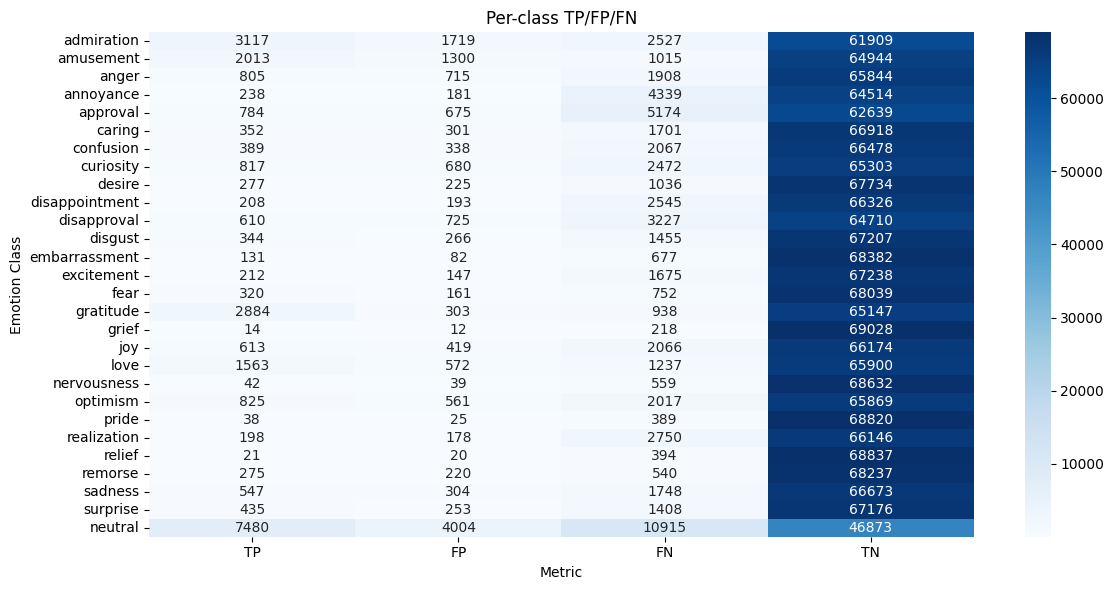

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(
    np.array([tp, fp, fn, tn]).T,
    annot=True,
    fmt='d',
    xticklabels=["TP", "FP", "FN", "TN"],
    yticklabels=emotion_columns,
    cmap="Blues"
)
plt.xlabel("Metric")
plt.ylabel("Emotion Class")
plt.title("Per-class TP/FP/FN")
plt.tight_layout()
plt.show()

### AUC-ROC Curve

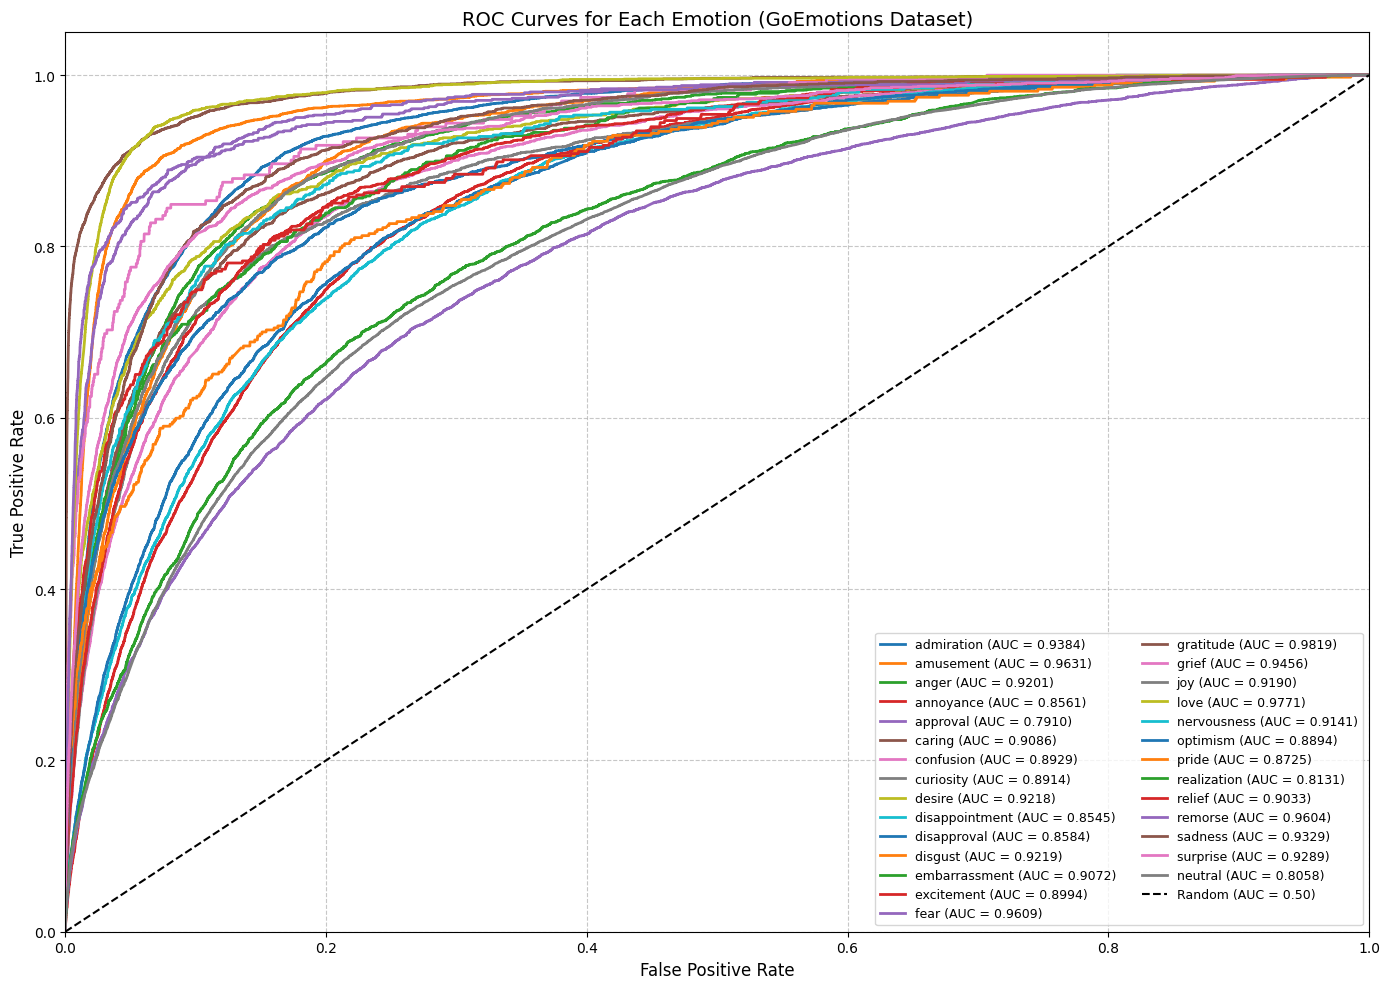

In [ ]:
plt.figure(figsize=(14, 10))  # Larger figure to fit 28 curves clearly

# Plot one ROC curve per emotion
for i, emotion in enumerate(emotion_columns):
    plt.plot(
        fpr[i],
        tpr[i],
        label=f"{emotion} (AUC = {roc_auc[i]:.4f})",
        linewidth=2
    )

# Add the random-guess line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for Each Emotion (GoEmotions Dataset)', fontsize=14)
plt.legend(loc='lower right', fontsize=9, ncol=2)  # 2 columns to fit all 28 labels neatly
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Word Cloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import math

def generate_all_emotion_wordclouds(dataframe, emotion_list):
    num_emotions = len(emotion_list)
    cols = 4
    rows = math.ceil(num_emotions / cols)

    plt.figure(figsize=(20, 4 * rows))
    stopwords = set(STOPWORDS)

    for i, emotion in enumerate(emotion_list):
        # Filter the dataframe for samples where this specific emotion is tagged
        text_subset = dataframe[dataframe[emotion] == 1]['cleaned_text'].astype(str)
        combined_text = " ".join(text_subset)

        # Ensure there is text available for this emotion
        if combined_text.strip():
            # Create the word cloud
            wc = WordCloud(
                background_color='white',
                max_words=80,
                stopwords=stopwords,
                width=400,
                height=250,
                colormap='plasma' if i % 2 == 0 else 'viridis'
            ).generate(combined_text)

            # Subplot arrangement
            plt.subplot(rows, cols, i + 1)
            plt.imshow(wc, interpolation='bilinear')
            plt.title(f'Emotion: {emotion.upper()}', fontsize=14, fontweight='bold')
            plt.axis('off')
        else:
            # Handle cases where an emotion might have no samples in the current subset
            plt.subplot(rows, cols, i + 1)
            plt.text(0.5, 0.5, 'No Data', ha='center', va='center')
            plt.title(f'Emotion: {emotion.upper()}', fontsize=14)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

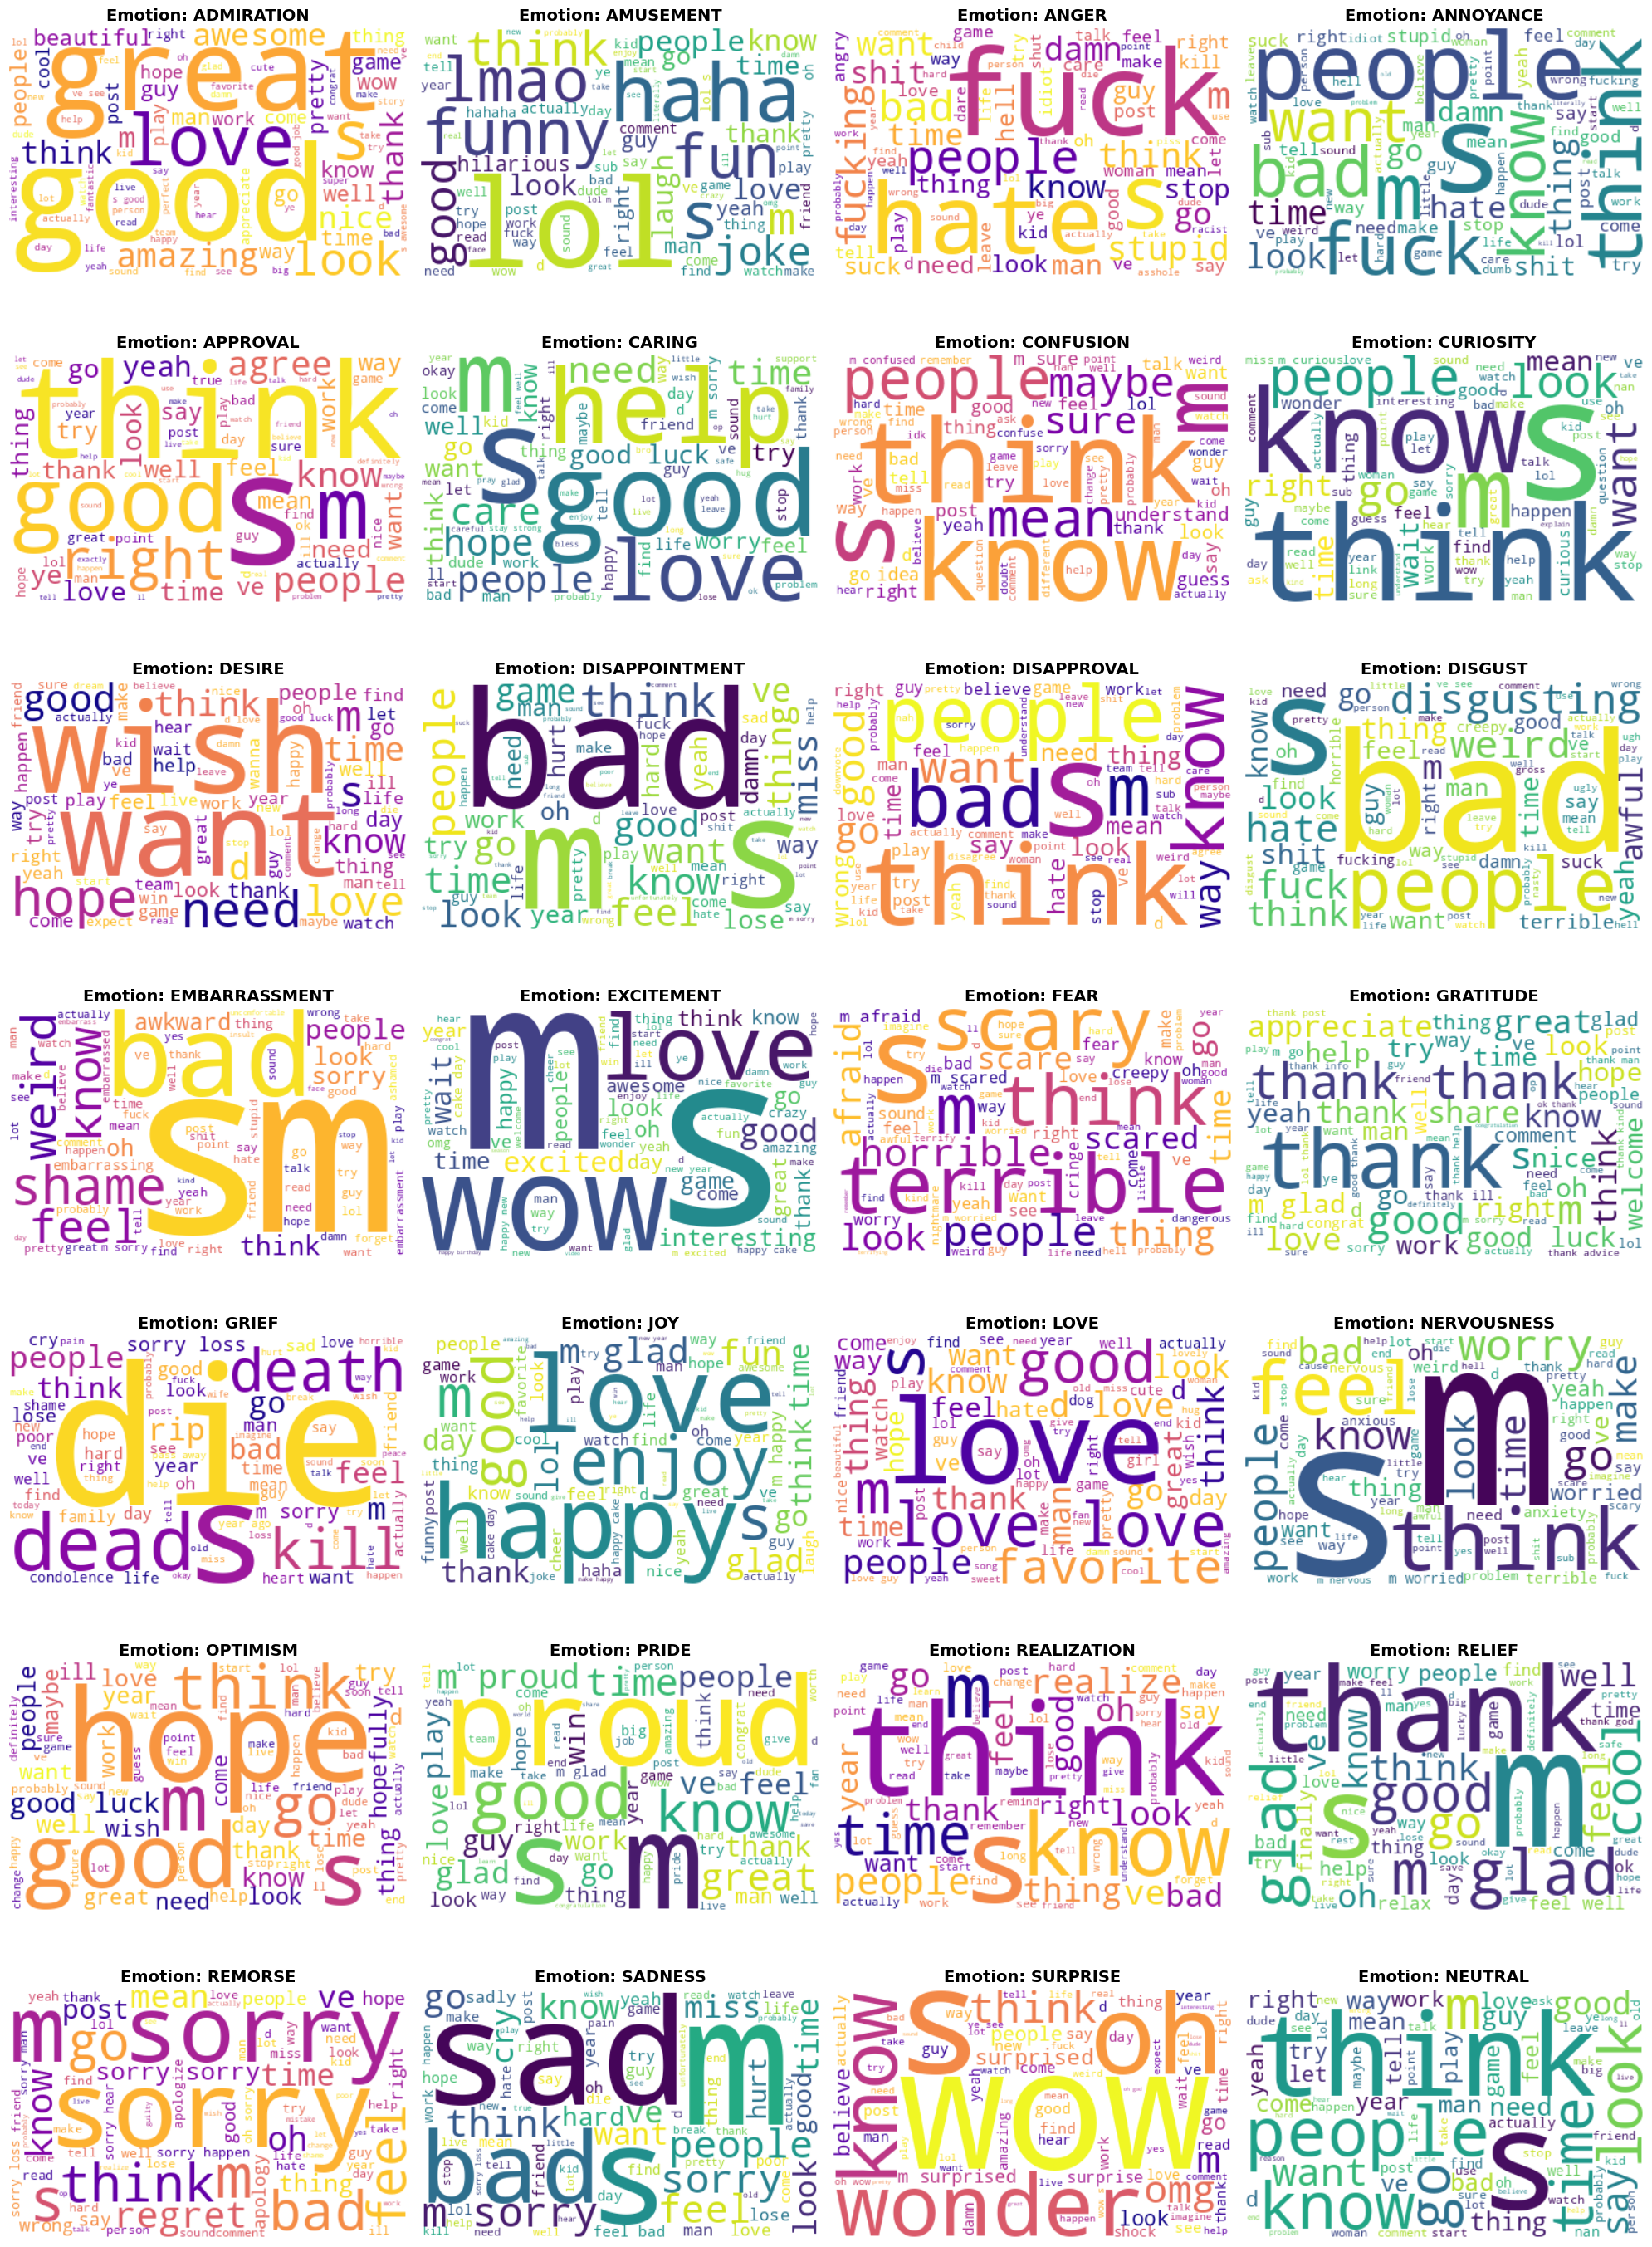

In [ ]:
generate_all_emotion_wordclouds(df, emotion_columns)